<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Neuronal Network based Trading Strategy

Continuing with the progression of implementing trading strategies with Artificial Intelligence models, we created a Neuronal Network model to predict the direction of a stock price. To do so, we built on top of our previous post of Modeling the stock Market through Machine Learning models and apply the solutions we figured out for the usual financial models.

Through Neuronal Networks modelling, we will encounter new challenges like the problem of over-fitting, the biggest problem at the moment of modelling financial data.

## Importing the required libraries

First, we begin by importing the libraries we used across the code. 
- `Yfinance` to download the daily prices from yahoo finance.
- `Numpy` and `Pandas` to manipulate the data.
- `Matplotlib` to create the charts
- `Tensorflow` and `Keras` to implement the neuronal network model

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(500)

### Graph Formating

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))         # size fo the graph

## Downloading the Data

The next step is to download the Microsoft (MSFT) historical price from Yahoo Finance. The window used is daily data from Jan-2010 to Jul-2020.

In [3]:
symbol = ["MSFT"]
rawdata = yf.download(symbol, start="2010-01-01", end="2020-07-25", interval = "1d")

rawdata = pd.DataFrame(rawdata['Close'])
rawdata.columns = ['price']

[*********************100%***********************]  1 of 1 completed


As we can observe in the graph, the Microsoft stock price has a positive trend, but it presents volatile moments that we tried to capitalize on the algorithmic strategy. 

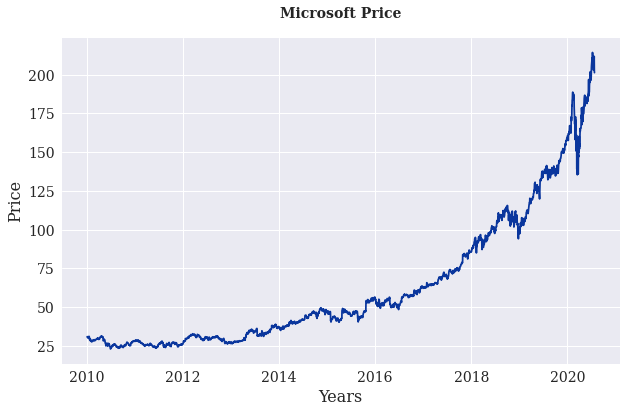

In [4]:
plt.figure()
plt.title('Microsoft Price',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Price')
plt.plot(rawdata, color='#0A369D');
# plt.savefig('price.png', facecolor='None')

## Preparing the data

After downloading the data, we proceed to calculate the different technical indicators that we used as features in the Neuronal Network model.
We calculated the logarithmic returns and afterword a column with its sign, the variable that we are going to try to predict. As we can tell in the formula, the variable `direction` is a binary feature that takes a value of 1 when the return is positive and 0 otherwise.

We also calculated 2 windows of Simple Moving Averages, Equally Weighted Moving Averages and Rolling Standard Deviations.

In [5]:
data = rawdata[:-1].copy()
data['returns'] = np.log(data/data.shift(1))
data['direction'] = np.where(data['returns'] > 0 , 1,0)


# Calculates Simple Moving Averages with a long and a short window
data['SMA1'] = data['price'].rolling(20).mean().shift(1)
data['SMA2'] = data['price'].rolling(60).mean().shift(1)
data['dSMA'] = data['SMA1'] - data['SMA2']

# Calculates Equally Weighted Moving Average with a long and a short halflife
data['EWMA1'] = data['price'].ewm(halflife=20).mean().shift(1)
data['EWMA2'] = data['price'].ewm(halflife=60).mean().shift(1)
data['dEWMA'] = data['EWMA1'] - data['EWMA2']

# Calculates the moving standard deviation
data['vol1'] = data['price'].rolling(20).std().shift(1)
data['vol2'] = data['price'].rolling(60).std().shift(1)

# Deletes NA rows
data.dropna(inplace=True)

data.tail()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
Date,,,,,,,,,,,
2020-07-17,202.880005,-0.005113,0,204.426000,190.072334,14.353666,192.202676,172.901406,19.301270,5.992706,11.791144
2020-07-20,211.600006,0.042083,1,204.754000,190.561667,14.192333,192.566385,173.245739,19.320646,5.697965,11.701458
2020-07-21,208.750000,-0.013560,0,205.576501,191.231334,14.345167,193.214740,173.686275,19.528465,5.419118,11.737109
2020-07-22,211.750000,0.014269,1,205.985500,191.801334,14.184166,193.743928,174.089017,19.654911,5.329316,11.743709
2020-07-23,202.539993,-0.044469,0,206.477500,192.429667,14.047833,194.357281,174.521590,19.835691,5.387163,11.786317


As a good practice, we split the data in training (70%) and test (30%) to evaluate our final model with data that the model hasn't seen.

In [6]:
split = int(len(data) * 0.7)
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [7]:
train.shape

(1817, 11)

In [8]:
test.shape

(780, 11)

We create a `backtest` data frame with the test returns that we use to backtest the trading strategy at the end of the study.

In [9]:
backtest=pd.DataFrame(test['returns'])

## Pre-processing the features

If we have a quick look at the data that we generated, we can see that all the variables are very different numerically among them. They have very different distributions, represented with the mean and std. Given that the neuronal network models prefer homogeneous features, we normalize them with the technique of moment matching, adjusting them by the mean and variance. 

Before normalizing them, we created 5 lags of every feature, considering that we can obtain useful information from previous observations.

In [10]:
test.describe()

,price,returns,direction,SMA1,SMA2,dSMA,EWMA1,EWMA2,dEWMA,vol1,vol2
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,120.067462,0.001362,0.569231,118.220007,114.991689,3.228318,115.318466,107.749919,7.568547,2.927770,4.975012
std,34.935040,0.019199,0.495502,33.649776,31.798556,4.656363,32.078852,29.272699,3.590359,2.382535,3.585582
min,68.169998,-0.159453,0.000000,69.767000,68.044000,-15.266666,68.456787,64.489750,1.355698,0.509160,1.004940
25%,93.777498,-0.006144,0.000000,92.410500,91.373208,1.001042,90.881468,83.881947,5.204873,1.564676,2.711254
50%,110.450001,0.001620,1.000000,108.911250,108.628084,2.959333,108.107541,103.675551,7.334794,2.268061,3.692789
75%,139.582500,0.010109,1.000000,138.263250,137.536125,5.555291,136.833791,129.035782,9.090493,3.043236,5.486270
max,214.320007,0.132929,1.000000,206.477500,192.429667,15.062499,194.357281,174.521590,19.835691,13.996962,15.446460


In [11]:
#Creating the lags
features = list(data.columns)
cols = list(data.columns)
for f in features:    
    #Create lags
    for lag in range(1, 5 + 1):
        col = f'{f}_lag_{lag}'
        cols.append(col)
        train[col] = train[f].shift(lag)
        test[col] = test[f].shift(lag)

train.dropna(inplace=True)
test.dropna(inplace=True)   

In [12]:
#Normalizes variables
for f in cols:    
    if 'rets' not in f and 'direction' not in f:
        Tmean = train[f].mean()
        Tstd  = train[f].std()
        train[f]= (train[f] - Tmean) / Tstd
        test[f] = (test[f]  - Tmean) / Tstd    

For simplicity at the moment of the modelling process, we divided the data frames into two.
The `X` that represent the features and `y` is the target variable to forecast.

In [13]:
y_train = pd.DataFrame(train['direction'])
y_test = pd.DataFrame(test['direction'])
X_train = train.drop(columns=['direction','returns','price']).copy()
X_test = test.drop(columns=['direction','returns','price']).copy()

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1812 entries, 2010-04-08 to 2017-06-16
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMA1             1812 non-null   float64
 1   SMA2             1812 non-null   float64
 2   dSMA             1812 non-null   float64
 3   EWMA1            1812 non-null   float64
 4   EWMA2            1812 non-null   float64
 5   dEWMA            1812 non-null   float64
 6   vol1             1812 non-null   float64
 7   vol2             1812 non-null   float64
 8   price_lag_1      1812 non-null   float64
 9   price_lag_2      1812 non-null   float64
 10  price_lag_3      1812 non-null   float64
 11  price_lag_4      1812 non-null   float64
 12  price_lag_5      1812 non-null   float64
 13  returns_lag_1    1812 non-null   float64
 14  returns_lag_2    1812 non-null   float64
 15  returns_lag_3    1812 non-null   float64
 16  returns_lag_4    1812 non-null   float64
 

Finally, we split the training data frame into training and validation so we can use that 2nd validation to fine-tune our model before making the final decision of our model with the test data frame.

In [15]:
split = int(len(X_train) * 0.7)
partial_X_train = X_train.iloc[split:].copy()
X_val = X_train.iloc[:split].copy()
partial_y_train = y_train.iloc[split:].copy()
y_val = y_train.iloc[:split].copy()

## Modelling the Neuronal Network

In [16]:
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


We proceed to compile the model with the Keras package. This time we created a simple Neural Network with two intermediate layers with 64 hidden units each. A third layer would be the output, with only one number representing the probability of a positive market return.

In [17]:
model = Sequential()
    
model.add(Dense(64, input_dim=63, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  
    
model.compile(loss='binary_crossentropy',  
                       optimizer='rmsprop',  
                       metrics=['acc'])  

The next step after establishing our model is to train it. In other words, we are trying to adjust our data to the previously defined model, setting the different weights of each layer.

In [18]:
history = model.fit(partial_X_train, 
                          partial_y_train, 
                          epochs=30, 
                          verbose=False,
                          validation_data=(X_val,y_val))

## Measuring the loss and accuracy of the model

Once we have our model fully trained, we can measure the evolution of our model's loss and accuracy. The loss function is the one that our model tries to minimize. In simple words could be the error of our model. On the other hand, the accuracy measures how good the model predicts the actual category of the stock return.

In [19]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

As we divided our data in Training and Validation, we can see the evolution of the loss minimized by the model, represented by the blue dots on the chart.

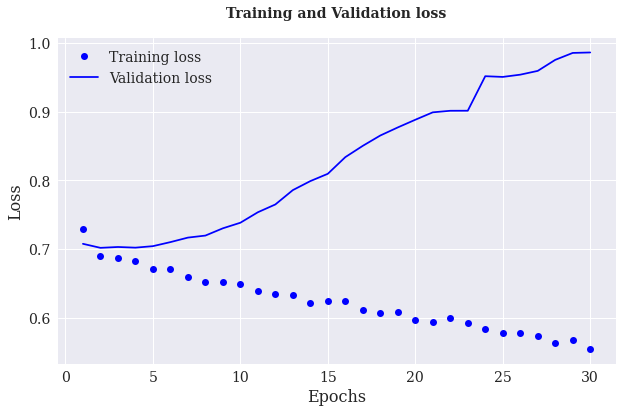

In [20]:
plt.plot(epochs, loss_values,'bo', label='Training loss')
plt.plot(epochs, val_loss_values,'b', label='Validation loss')
plt.title('Training and Validation loss',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
# plt.savefig('Loss.png', facecolor='None')

We can also see the how the accuracy rises as the model progress in the training.

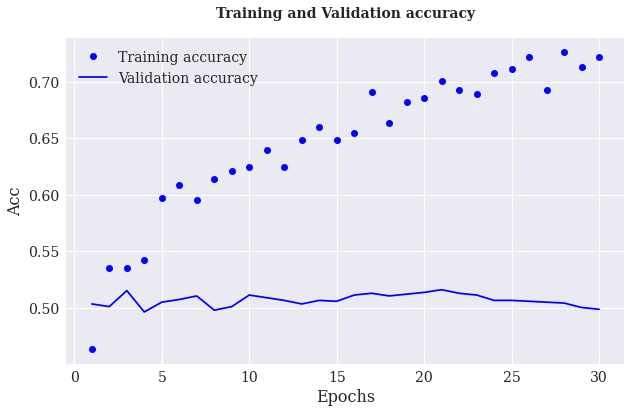

In [21]:
plt.plot(epochs, acc_values,'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values,'b', label='Validation accuracy')
plt.title('Training and Validation accuracy',fontweight="bold", pad=20)
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend();
# plt.savefig('Accuracy.png', facecolor='None')

However, if we observe the blue line in the loss and accuracy, we can tell that the model doesn't do a good job with out-of-sample data. This problem is known as over-fitting and is very common when trying to model financial data.

## Backtesting the model

The final step of this study is to evaluate the model through a vectorized backtesting with the test data that we haven't used in the modelling process. Before that, we can do a simple calculation to check how many of the model's predictions are right.

In [22]:
accuracy_score(model.predict(X_test).round(), y_test)

0.5703225806451613

We can see that the model is correct 57% of the times. Even though it is a first approximation, that number does not tell us if the strategy is profitable vs. having the stock. That is why we proceed to calculate the cumulative return of the strategy vs the stock.

In [27]:
backtest = backtest[5:].copy()

backtest['pred']=model.predict(X_test).round()
backtest['pred']=np.where(backtest['pred']==1,1,-1)  

backtest['strategy'] = backtest['pred'] * backtest['returns']

From the chart, we can conclude that the strategy is not effective, given that its return is almost the same as holding the stock.  If we take into consideration the transaction costs, the strategy wouldn't be profitable at all.

The good news is that the neuronal network that we modelled was very basic. We can still change the hyperparameters of it to adjust the training data to our model or try new techniques like recurrent neuronal networks that are ideal for predicting time series.

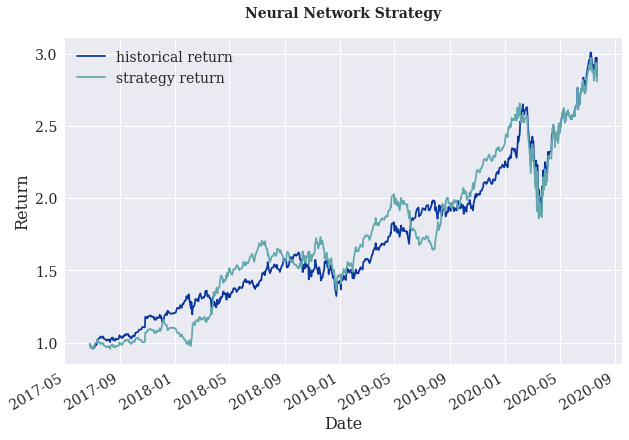

In [28]:
plt.figure()
plt.title('Neural Network Strategy',fontweight="bold", pad=20)
plt.xlabel('Date')
plt.ylabel('Return')
plt.plot(backtest['returns'].cumsum().apply(np.exp), label='historical return', color='#0A369D')
plt.plot(backtest['strategy'].cumsum().apply(np.exp), label='strategy return', color='#62a8ac')
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');
# plt.savefig('classification_strategy.png', facecolor='None')

## Conclusion

As we move forward, looking for the perfect Algorithmic Trading Strategy, we progressed into more complex models. Even though Neuronal Networks adapt better to the market's behaviour, we encounter the problem of over-fitting that we will try to solve in future posts. As we progress, we will try to be closer to reality, adding transaction costs and switching from vectorized backtesting to event-based backtesting. 

We will also try to build more complex Neuronal Networks to solve the problem of over-fitting, including the optimization of hyperparameters and modelling Recurrent Neuronal Networks.

## References

Inspired by the book *Artificial Intelligence for Finance* by Yves Hilpisch.

<img src="https://images-na.ssl-images-amazon.com/images/I/51VEL0RZbzL._SX379_BO1,204,203,200_.jpg" width="250" style="float:left">

and the book *Deep Learning with Python* by François Chollet.

<img src="https://images-na.ssl-images-amazon.com/images/I/41PYcD28fIL._SX397_BO1,204,203,200_.jpg" width="250" style="float:left">


<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>